### Compare vapor pressure trends in different reanalysis datasets with those in the station data.
### Also comparing the different methods (calculated based on specific humidity or based on dew point temperature for JRA-55

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import calendar_utils as cal

import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Arial')

import xesmf as xe


In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
landfrac = xr.open_dataset("../../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = xr.where(landfrac > 0, 1, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

### Map data

In [4]:
#---ISD
isddat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")

# drop stations that have more than 48 months with less than 15 bad days
dropstations=[]
for istation in np.arange(0,isddat.station.size,1):
    test = isddat.nbaddays.isel(station=istation)
    test = test.where( test > 15, drop=True)
    if (test.size >= 48):
        badstation = np.array_str(isddat.station.isel(station=istation).values)
        dropstations.append(badstation)
isddat = isddat.drop_sel(station=dropstations)

# drop the lons and lats for now
lons = isddat.lons ; lats = isddat.lats
isddat = isddat.drop_vars(['lons','lats'])

# compute the seasonal cycle
isd_seascyc = isddat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_deseas = isddat.groupby('time.month') - isd_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
isd_seascyc = isd_seascyc.rename({"month":"time"})
isd_seascyc['time'] = isddat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_seascyc_am = cal.calcannualmean(isd_seascyc)

# annual average of seasonalized anomalies
isd_deseas_am = cal.calcannualmean(isd_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_seascyc_am = isd_seascyc_am.expand_dims({"otheryrs":isd_deseas_am.year.size})
isd_seascyc_am = isd_seascyc_am.stack(z=("year","otheryrs"))
isd_seascyc_am = isd_seascyc_am.reset_index('z', drop=True).rename(z="year")
isd_seascyc_am = isd_seascyc_am.assign_coords({'year':isd_deseas_am.year})

# add back in the annual average climatology
isd_am = isd_seascyc_am + isd_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
isdmap = xr.apply_ufunc(linfit.compute_slope, isd_am, vectorize=True, input_core_dims=[['year']])*isd_am.year.size
isdmap = xr.merge([isdmap, lons, lats])
isdmap = isdmap.dropna('station')

In [5]:
#----HadISDH

#---ISD
#hadisdhdat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_HadISDH.nc")
hadisdhdat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/HadISDH/"+
                             "vp_direct_HadISDH_stations.nc")

lons = hadisdhdat.lon ; lats = hadisdhdat.lat
hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])
#hadisdhdat = hadisdhdat.vp_fromhadisdh
hadisdhdat = hadisdhdat.vp

badvp = xr.where( np.isnan(hadisdhdat), 1, 0)
nbadvp = badvp.sum("time")
hadisdhdat = hadisdhdat.where( nbadvp < 48, drop=True)

# drop the lons and lats for now
#lons = hadisdhdat.lon ; lats = hadisdhdat.lat
#hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])

# compute the seasonal cycle
hadisdh_seascyc = hadisdhdat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_deseas = hadisdhdat.groupby('time.month') - hadisdh_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
hadisdh_seascyc = hadisdh_seascyc.rename({"month":"time"})
hadisdh_seascyc['time'] = hadisdhdat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_seascyc_am = cal.calcannualmean(hadisdh_seascyc)

# annual average of seasonalized anomalies
hadisdh_deseas_am = cal.calcannualmean(hadisdh_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_seascyc_am = hadisdh_seascyc_am.expand_dims({"otheryrs":hadisdh_deseas_am.year.size})
hadisdh_seascyc_am = hadisdh_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_seascyc_am = hadisdh_seascyc_am.reset_index('z', drop=True).rename(z="year")
hadisdh_seascyc_am = hadisdh_seascyc_am.assign_coords({'year':hadisdh_deseas_am.year})

# add back in the annual average climatology
hadisdh_am = hadisdh_seascyc_am + hadisdh_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
hadisdhmap = xr.apply_ufunc(linfit.compute_slope, hadisdh_am, vectorize=True, input_core_dims=[['year']])*hadisdh_am.year.size
hadisdhmap = hadisdhmap.rename('vp')
hadisdhmap = xr.merge([hadisdhmap, lons, lats])
hadisdhmap = hadisdhmap.dropna('station')


In [45]:
print(isdmap.station.size)
print(hadisdhmap.station.size)

2581
2457


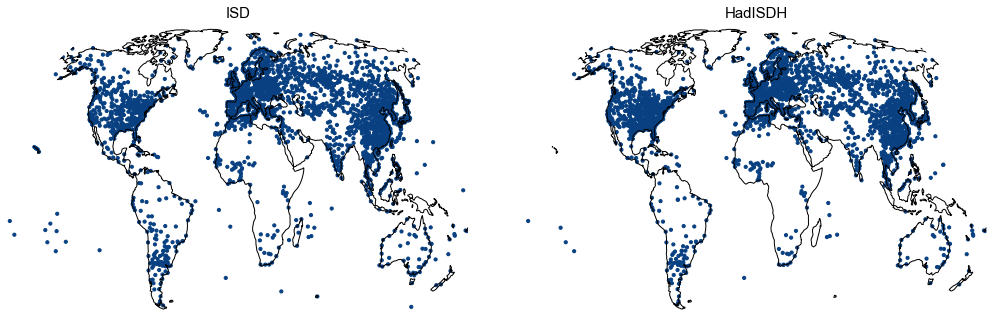

In [6]:
fig = plt.figure(figsize=(16,16))
ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isdmap.vp*0 + 1, isdmap.lons, isdmap.lats, 0.1, -1, 1, 'ISD',
                                                                    0.05,0.45,0.75,1,cmap='precip')

ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, hadisdhmap.vp*0 + 1, hadisdhmap.lon, hadisdhmap.lat,0.1,-1,1,'HadISDH',
                                                                    0.5,0.9,0.75,1,cmap='precip')

In [7]:

era5_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_ERA5.nc")
era5_map['lon'] = landfrac.lon ; era5_map['lat'] = landfrac.lat
jra55_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_JRA55.nc")
jra55_map['lon'] = landfrac.lon ; jra55_map['lat'] = landfrac.lat
#jra55fromq_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_JRA55_fromq.nc")
#jra55fromq_map['lon'] = landfrac.lon ; jra55fromq_map['lat'] = landfrac.lat
merra2_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_MERRA2.nc")
merra2_map['lon'] = landfrac.lon ; merra2_map['lat'] = landfrac.lat
hadisdh_map_gridded = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_HadISDH.nc")

In [8]:
grid_out = xr.Dataset({'latitude': (['latitude'], hadisdh_map_gridded.latitude.values)}, {'longitude':(['longitude'], 
                                                        hadisdh_map_gridded.longitude.values)})
regridder = xe.Regridder(landfrac, grid_out, 'bilinear', periodic=True, reuse_weights=False,
                              filename="/project/cas/islas/temp/wgtfile.nc")
hadisdh_landfrac = regridder(landfrac)
hadisdh_landfrac = xr.where( hadisdh_landfrac > 0, 1, nan)
hadisdh_landfrac = hadisdh_landfrac.where( hadisdh_landfrac > -60, nan)

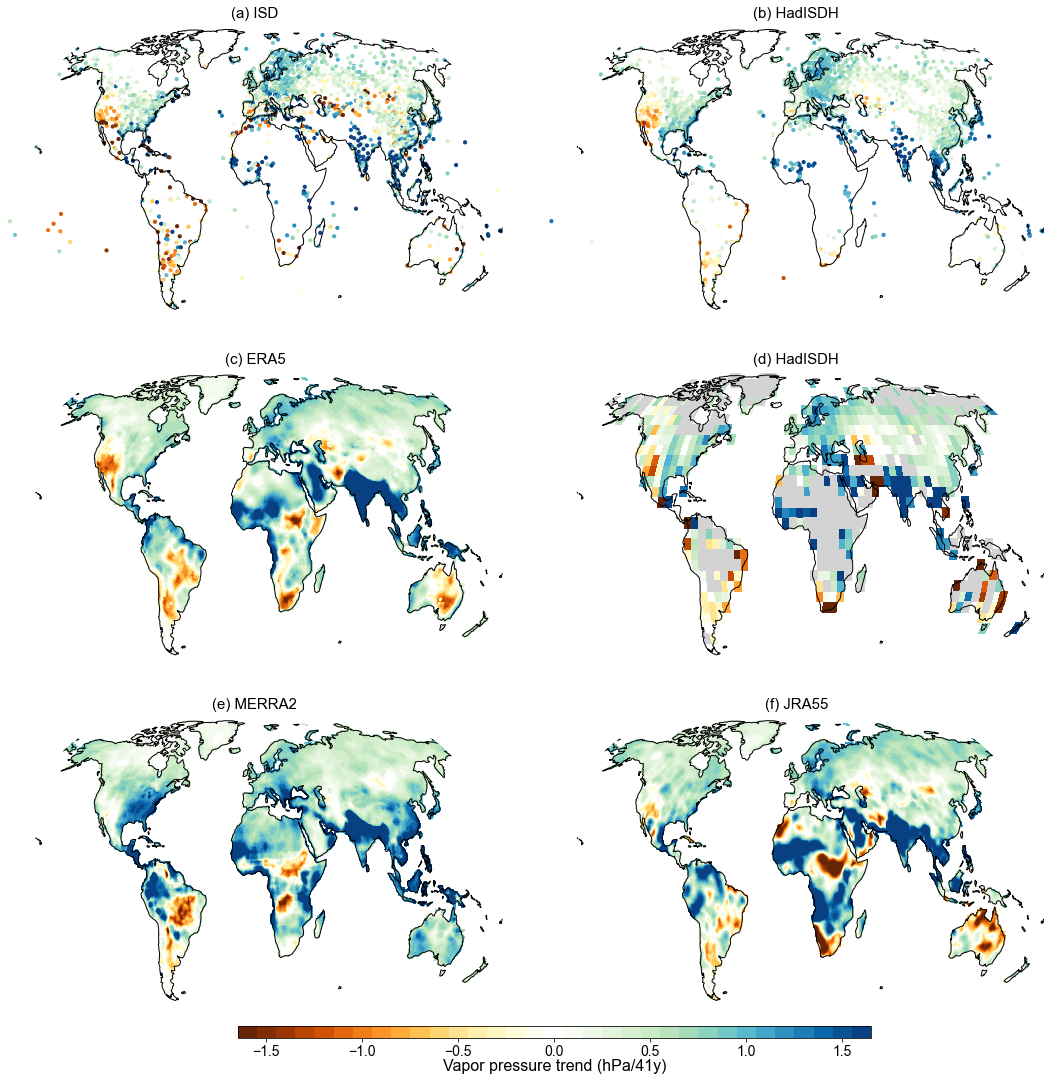

In [9]:
fig = plt.figure(figsize=(16,16))

ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isdmap.vp, isdmap.lons, isdmap.lats, 0.1, -1.6, 1.6, '(a) ISD',
                                                                    0.05,0.48,0.75,1,cmap='precip')

ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, hadisdhmap.vp, hadisdhmap.lon, hadisdhmap.lat, 0.1 ,-1.6, 1.6, '(b) HadISDH',
                                                                    0.52,0.95,0.75,1,cmap='precip')

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5_map.vp*landfrac, era5_map.lon, era5_map.lat,0.1,-1.6,1.6,'(c) ERA5',
                                           0.05,0.48,0.45,0.7,cmap='precip')

#----HadISDH
#signifdat = xr.where( (hadisdh_map_gridded.vp == 0) & (hadisdh_landfrac == 1), 1, nan)
signifdat = xr.where( np.isnan(hadisdh_map_gridded.vp) & (hadisdh_landfrac == 1), 1, nan)
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, hadisdh_landfrac*hadisdh_map_gridded.vp, hadisdh_map_gridded.longitude, 
                                                              hadisdh_map_gridded.latitude, 
                                                              0.1, -1.5, 1.5, '(d) HadISDH',0.52,0.95,0.45,0.7,cmap='precip', signifdat=signifdat)

#------MERRA2
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, merra2_map.vp*landfrac, merra2_map.lon, merra2_map.lat, 0.1, -1.6, 1.6,'(e) MERRA2',
                                             0.05,0.48,0.15,0.4,cmap='precip')

#ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, merra2_map.vp*landfrac, merra2_map.lon, merra2_map.lat, 0.2, -2, 2,'(d) MERRA2',
#                                             0.52,0.95,0.45,0.7,cmap='precip')


#----JRA55
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, jra55_map.vp*landfrac, jra55_map.lon, jra55_map.lat, 0.1, -1.6,1.6,'(f) JRA55',
                                             0.52,0.95,0.15,0.4,cmap='precip')


ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6,'Vapor pressure trend (hPa/41y)', 0.25,0.8,0.12,0.13,cmap='precip')

fig.savefig(plotpath+'figS6.pdf', bbox_inches='tight', facecolor='white')

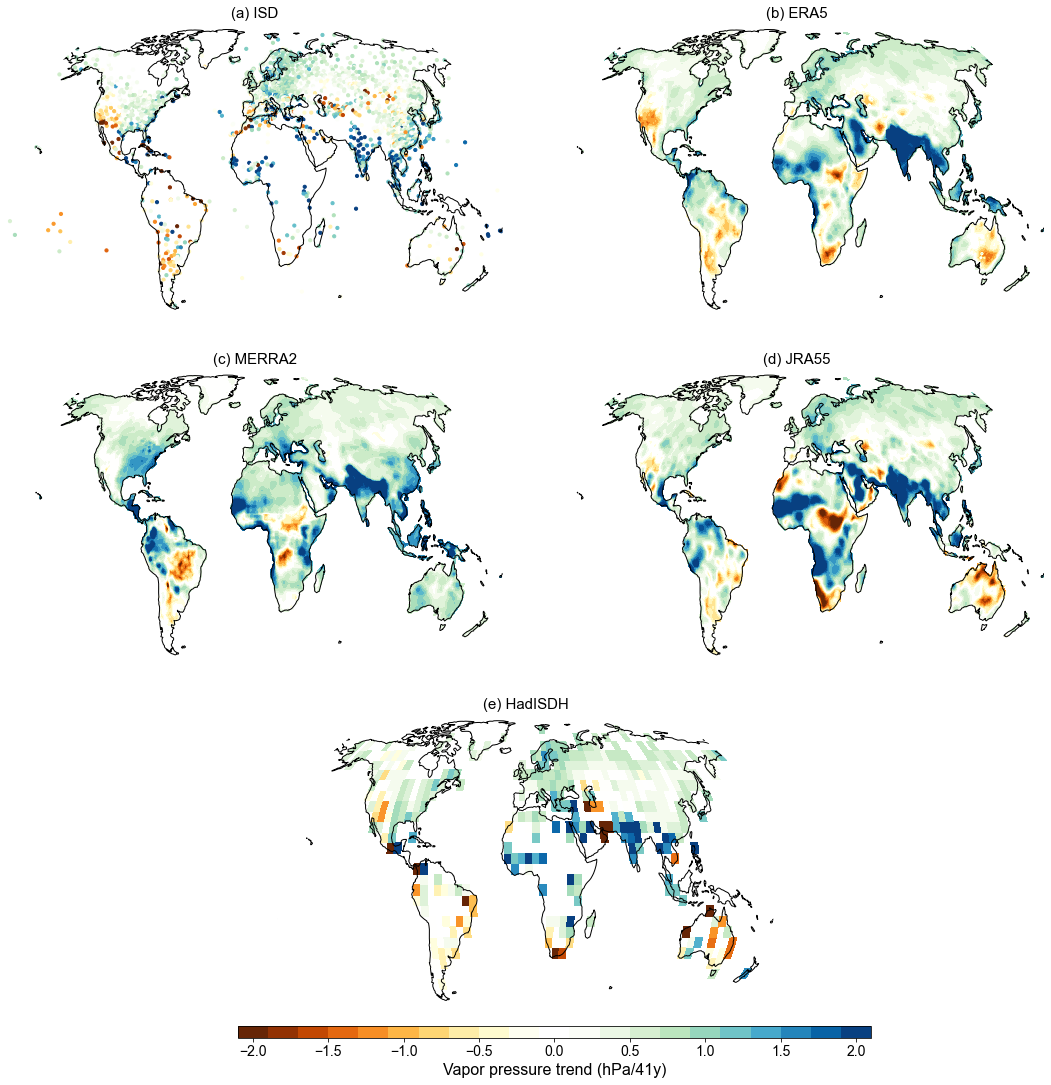

In [20]:
fig = plt.figure(figsize=(16,16))

#------ISD map
ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isdmap.vp, isdmap.lons, isdmap.lats, 0.2,-2,2,'(a) ISD',
                                                0.05,0.48,0.75,1,cmap='precip')

#------ERA5 map
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5_map.vp*landfrac, era5_map.lon, era5_map.lat,0.2,-2,2,'(b) ERA5',
                                           0.52,0.95,0.75,1,cmap='precip')

#------MERRA2
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, merra2_map.vp*landfrac, merra2_map.lon, merra2_map.lat, 0.2, -2, 2,'(c) MERRA2',
                                             0.05,0.48,0.45,0.7,cmap='precip')


#----JRA55
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, jra55_map.vp*landfrac, jra55_map.lon, jra55_map.lat, 0.2, -2,2,'(d) JRA55',
                                             0.52,0.95,0.45,0.7,cmap='precip')

#----HadISDH
signifdat = xr.where( (hadisdh_map_gridded.vp == 0) & (hadisdh_landfrac == 1), 1, nan)
ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, hadisdh_landfrac*hadisdh_map_gridded.vp, hadisdh_map_gridded.longitude, 
                                                              hadisdh_map_gridded.latitude, 
                                                              0.2, -2, 2, '(e) HadISDH',0.285,0.715,0.15,0.4,cmap='precip', signifdat=signifdat)


ax = cbars.plotcolorbar(fig, 0.2, -2, 2,'Vapor pressure trend (hPa/41y)', 0.25,0.8,0.12,0.13,cmap='precip')

#fig.savefig(plotpath+'compare_reanalysis_isd_globalmaps.pdf', bbox_inches='tight', facecolor='white')

In [44]:
import importlib
importlib.reload(mymaps)
from matplotlib import colors as c
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

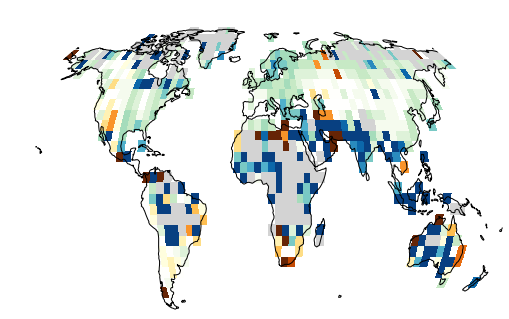

In [45]:
fig = plt.figure(figsize=(16,16))

signifdat = xr.where( (hadisdh_map.vp == 0) & (hadisdh_landfrac == 1), 1, nan)

ax = mymaps.contourmap_bothcontinents_robinson_pcolormesh_pos(fig, hadisdh_landfrac*hadisdh_map.vp, hadisdh_map.longitude, hadisdh_map.latitude, 
                                                              0.2, -2, 2, ' ',0.05,0.48,0.75,1,cmap='precip', signifdat=signifdat)
                                                              
#mygraymap = c.ListedColormap(['lightgray','lightgray'])
#graynorm = BoundaryNorm([0,1], ncolors=mygraymap.N, clip=True)
#ax.pcolormesh(signifdat.longitude,signifdat.latitude,signifdat,cmap=mygraymap, norm=graynorm,
#              transform=ccrs.PlateCarree())
    

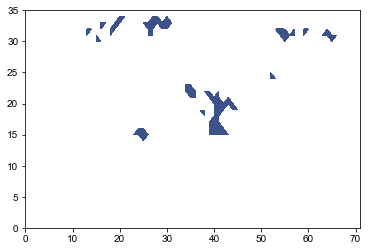

In [19]:
plt.contourf(signifdat)

In [26]:
print(hadisdh_map.vp.sel(latitude=0, method='nearest'))

<xarray.DataArray 'vp' (longitude: 72)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
    latitude   float32 2.5
  * longitude  (longitude) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
